# Comparison of models with cross validation

In [1]:
library(caret)
library(magrittr)
library(MLmetrics)
source("helpers.r")
df  <- get_training_df_clean()

Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall

Warning message:
"package 'tidyverse' was built under R version 3.6.1"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract()   masks magrittr::extract()
x dplyr::filter()    masks stats::filter()
x dpl

I use the AUC within a 10 fold cross validation. First let's define the two learners, that receive a training and test data set:

In [2]:
learner_A <- function(training, test) {
  name <- "full model"

  fit <- glm(target ~ ., data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_B <- function(training, test) {
  name <- "restricted model"
  
  fit <- glm(target ~ chol + age, data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

No I can run the cross validation: 

In [3]:
cross_validation <- function(learner_A, learner_B, df){
  set.seed(25)
  number_of_folds <- 10
  folds <- createFolds(df$target, k = number_of_folds)
  model_result <- tibble(model = vector("character"),
                         auc = vector("numeric"))
  
  for(fold_index in c(1:number_of_folds)){
    training <- df[-folds[[fold_index]],]
    test <- df[folds[[fold_index]],]
    
    result_A<- learner_A(training, test)
    result_B <- learner_B(training, test)
    
    model_result %<>%
      add_row(model = result_A[[1]], auc = result_A[[2]]) %>%
      add_row(model = result_B[[1]], auc = result_B[[2]])
    
  }
  
  return(model_result)
  
}

cv_result  <- cross_validation(learner_A, learner_B, df)

To do some statistical inference I implemented the 5 x 2 cross validation t test from *Dietterich, Thomas: Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms 1997*:

In [4]:
cross_validation_52 <- function(learner_A, learner_B, df){
  p_1_t <- 0
  s = vector(mode = "numeric", length = 5)
  
  for(i in c(1:5)) {
    set.seed(25 + i)
    number_of_folds <- 2
    folds <- createFolds(df$target, k = number_of_folds)
    
    for(fold_index in c(1:number_of_folds)){
      S_1 <- df[-folds[[fold_index]],]
      S_2 <- df[folds[[fold_index]],]
      
      A_p_1 <- learner_A(training = S_1, test = S_2)[["auc"]]
      B_p_1 <- learner_B(training = S_1, test = S_2)[["auc"]]
      
      A_p_2 <- learner_A(training = S_2, test = S_1)[["auc"]]
      B_p_2 <- learner_B(training = S_2, test = S_1)[["auc"]]
      
      p_1 <-  A_p_1 - B_p_1
      p_2 <-  A_p_2 - B_p_2
      p_mean <-  (p_1 + p_2) / 2
      
      s[i] <- (p_1 - p_mean) *  (p_1 - p_mean) + (p_2 - p_mean) *  (p_2 - p_mean) 
      
      if(i == i) p_1_t <- p_1
    }
  }
  
  t <- p_1_t / sqrt(mean(s))
  p_value <- (1 - pt(t, df = 5)) * 2
  
  return(list(t = t, p_value = p_value))
}

cv_52_result <- cross_validation_52(learner_A, learner_B, df)

With these two functions I plot the result of the cross validation:

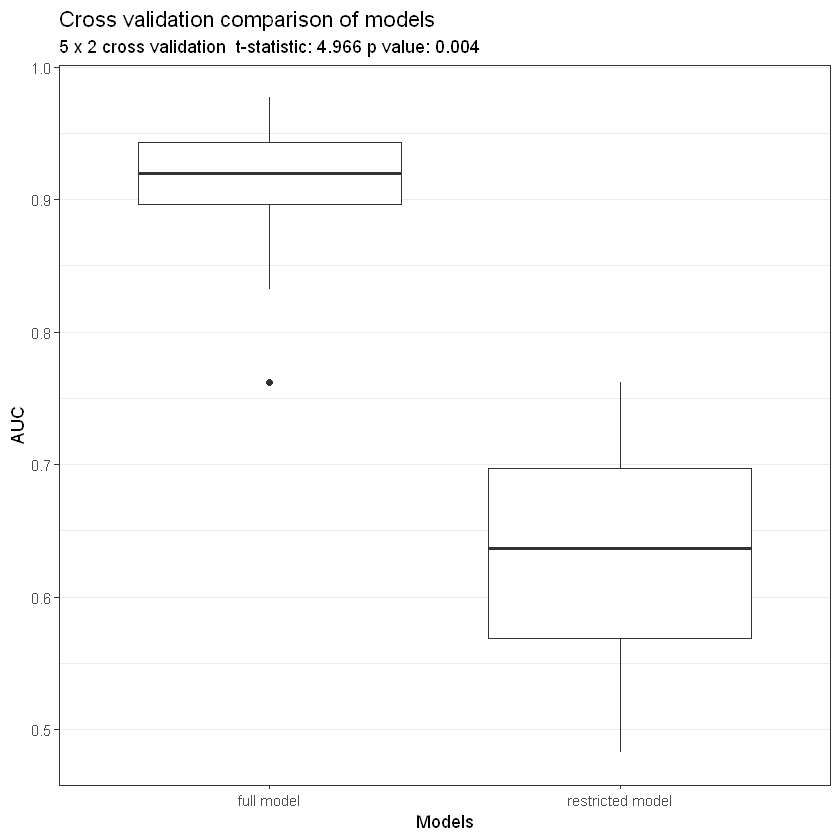

In [5]:
plot_result <- function(cv_result, t, p_value){
  
  models <- (cv_result %>% distinct(model))[["model"]]
  cv_result %>%
    mutate(model = factor(model, levels = models)) %>%
    ggplot(aes(x = model, y = auc))+
    geom_boxplot() +
    labs(
      x = "Models",
      y = "AUC",
      title = "Cross validation comparison of models",
      subtitle = paste0("5 x 2 cross validation  t-statistic: ",round(t,3), " p value: ", round(p_value,3))
    ) + 
    theme_bw() + 
    theme(panel.grid.major.x = element_blank(),
          plot.title = element_text(hjust = 0)
    )
}

plot_result(cv_result, cv_52_result$t,  cv_52_result$p_value)

The 10 fold cross validation is used to visualize the result and with the 5 x 2 cross validation one can calculate a p value. The full model performs here significant better than the restricted model. I added the functions to the `helpers.r` script and combined both into the `cross_validation_selection.r` script. So I just call the following to receive the results:

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)
Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


model,mean,median,sd
full model,0.9035265,0.9195804,0.06323870
restricted model,0.6326673,0.6363636,0.09231759


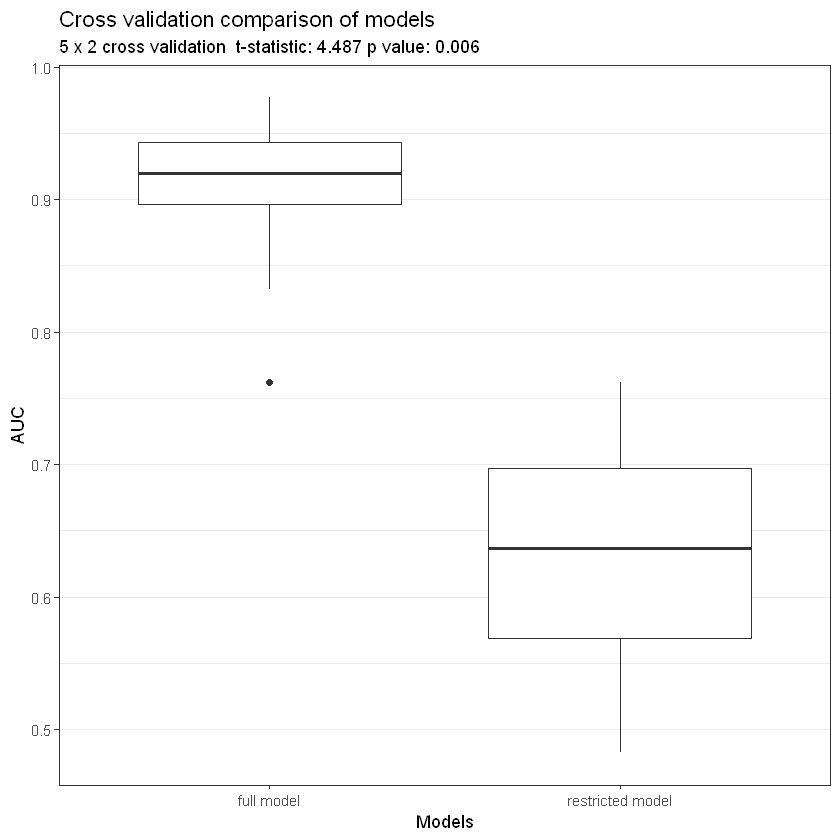

In [6]:
rm(list = ls())
source("helpers.r")

learner_A <- function(training, test) {
  name <- "full model"

  fit <- glm(target ~ ., data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_B <- function(training, test) {
  name <- "restricted model"
  
  fit <- glm(target ~ chol + age, data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}


result <- cross_validation_selection(learner_A, learner_B)

result$model_result %>%
   group_by(model) %>%
   summarize(mean = mean(auc),
             median = median(auc),
             sd = sd(auc))

plot_result(result)